In [2]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.__version__

'2.0.0+cu117'

In [4]:
# You can ensure your code will run on either setup by creating a device object 
# that points either to the CPU or, if one is available, to the GPU:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)


cuda


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


In [6]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)


In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


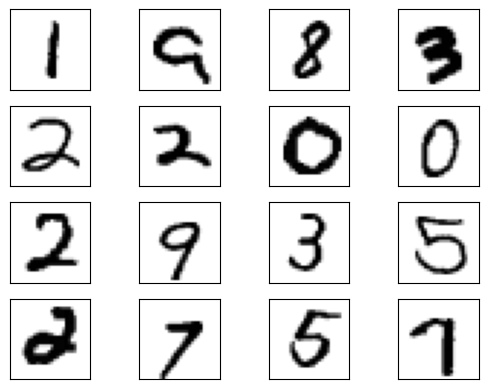

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output


In [10]:
discriminator = Discriminator().to(device=device)


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


generator = Generator().to(device=device)


In [12]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.5351767539978027
Epoch: 0 Loss G.: 0.5400190353393555
Epoch: 1 Loss D.: 0.05856839567422867
Epoch: 1 Loss G.: 4.893281936645508
Epoch: 2 Loss D.: 0.05629910156130791
Epoch: 2 Loss G.: 7.887269020080566
Epoch: 3 Loss D.: 0.08916729688644409
Epoch: 3 Loss G.: 5.013260364532471
Epoch: 4 Loss D.: 0.054945338517427444
Epoch: 4 Loss G.: 4.524433135986328
Epoch: 5 Loss D.: 0.06996746361255646
Epoch: 5 Loss G.: 4.227270126342773
Epoch: 6 Loss D.: 0.21035027503967285
Epoch: 6 Loss G.: 3.641148805618286
Epoch: 7 Loss D.: 0.4806686043739319
Epoch: 7 Loss G.: 2.734503746032715
Epoch: 8 Loss D.: 0.3138192594051361
Epoch: 8 Loss G.: 2.0007758140563965
Epoch: 9 Loss D.: 0.4968428909778595
Epoch: 9 Loss G.: 2.1415746212005615
Epoch: 10 Loss D.: 0.4016905426979065
Epoch: 10 Loss G.: 1.7219324111938477
Epoch: 11 Loss D.: 0.35403376817703247
Epoch: 11 Loss G.: 1.412929654121399
Epoch: 12 Loss D.: 0.41603541374206543
Epoch: 12 Loss G.: 1.3458576202392578
Epoch: 13 Loss D.: 0.4734277129

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)


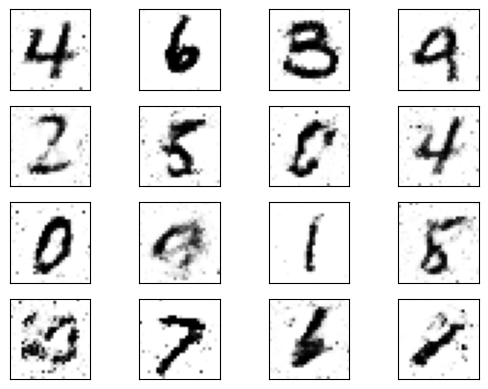

In [15]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
